# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

## Reading the data from SQLITE
1. We are going to classify our data using the attribute "SCORE" from our dataframe
2. SCORE > 3 is classified as Positive review, SCORE < 3 is classified as Negative review
3. Since SCORE = 3 is Neutral, we will not consider those reviews in our classiication

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

### Data Cleaning: Removing miscategorized data points

1. The products "B00004CI84" and "B00004CXX9" belong to movie category. Since the product name contains the word "Juice", it has been miscategorized under food.

2. "B0002YW26E" is a Pest control product. Miscategorized as food.

3. The products "6641040" and "2841233731" are CookBooks.

In [14]:
# Removing the miscategorized products from the data

final_data=final[~final.ProductId.isin (['B0002YW26E','B00004CI84','B00004CXX9','6641040','2841233731'])]
print("Number of final points in our data",final_data.shape)

Number of final points in our data (363896, 10)


In [15]:
#How many positive and negative reviews are present in our dataset?
print(final_data['Score'].value_counts())

1    306829
0     57067
Name: Score, dtype: int64


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_238 = final_data['Text'].values[238]
print(sent_238)
print("*"*100)

# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_238 = re.sub(r"http\S+", "", sent_238)
print(sent_238)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

print(sent_238)
print("*"*100)
soup = BeautifulSoup(sent_238, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

sent_79290 = final_data['Text'].values[79290]
print(sent_79290)
print("*"*100)
sent_79290 = decontracted(sent_79290)
print(sent_79290)

I buy these at Christmas time to stuff for parties.  They are a hit and getting hard to find.  :) Some wait for my tray of stuffed peppers with anticipation, and will be disappointed this year if I can't find them.
****************************************************************************************************
I buy these at Christmas time to stuff for parties.  They are a hit and getting hard to find.  :) Some wait for my tray of stuffed peppers with anticipation, and will be disappointed this year if I can not find them.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
print(text)
print("*"*100)
text = re.sub("\S*\d\S*", "", text).strip()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here? />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
text = re.sub('[^A-Za-z0-9]+', ' ', text)
print(text)

Why is this when the same product is available for here The Victor and traps are unreal of course total fly genocide Pretty stinky but only right nearby 


In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 363896/363896 [02:29<00:00, 2433.41it/s]


In [25]:
preprocessed_reviews[1600]

'cats love product not worry clay getting digested cats family matter one cats getting sick clay tried since natural voila healthy kitties sure may not work new fangled litter boxes not think made scoop litter must sit probably min stay ball love counts plus price awesome usually travel half hours get shipping worth gas travel time thank'

In [26]:
final_data['CleanedText']=preprocessed_reviews #adding a column of CleanedText which displays the data after pre-processing of review
print(final_data['CleanedText'].values[100])

purchased several different brands liver treats best terms good size pieces small bits little powder


In [27]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())

100%|██████████| 363896/363896 [01:38<00:00, 3689.04it/s]


In [28]:
print(final_data['Summary'].values[101])
print("*"*100)
print(preprocessed_summary[101])

My dog would do anything for this treat
****************************************************************************************************
dog would anything treat


In [29]:
final_data['CleanedSummary']=preprocessed_summary #adding a column of CleanedText which displays the data after pre-processing of summary review
print(final_data['CleanedSummary'].values[201])

delicious mildly sweet cookie


In [30]:
final_data['FinalReview']= final_data['CleanedText'] + str(" ") + final_data['CleanedSummary']
print(final_data['CleanedText'].values[100])
print(final_data['CleanedSummary'].values[100])
print("*"*100)
print(final_data['FinalReview'].values[100])

purchased several different brands liver treats best terms good size pieces small bits little powder
good quality
****************************************************************************************************
purchased several different brands liver treats best terms good size pieces small bits little powder good quality


In [31]:
final_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText', 'CleanedSummary', 'FinalReview'],
      dtype='object')

# [4] Assignment 7: SVM

In [31]:
# Taking 100k points from our dataset

final_sample = final_data.sample(n=100000)
print(final_sample.shape)
print(final_sample["Score"].shape)

(100000, 13)
(100000,)


In [32]:
word_count= []
for sentence in final_sample['FinalReview'].values:
    total_words= len(sentence.split())
    word_count.append(total_words)
    
print(final_sample['FinalReview'].values[12])
print("The number of words in the above review is: ", word_count[12])

gevalia morning roast fills coffee cup top no room creamer could forgive use larger mug not forgive lack flavor listed medium find weak tasteless full disclosure like bold coffees update find box coffee workaround lack flavor turn machine coffee level level normal oz cup coffee find something taste leave rest water big mug not big enough flavor
The number of words in the above review is:  57


In [33]:
final_sample['word_count']=word_count 
print(final_sample['FinalReview'].values[5])
print("*"*100)
print(final_sample['word_count'].values[5])

girl scout troop represented switzerland recent thinking day years theme foods around world mini toblerone bars perfect service wonderful candy company got plenty time perfect size others sample love
****************************************************************************************************
29


In [34]:
# Sorting the data based on time

final_sample.sort_values(by='Time', ascending=True, inplace=True)
print(final_sample['Time'].head(1))
print(final_sample['Time'].tail(1))

138706    939340800
Name: Time, dtype: int64
206062    1351209600
Name: Time, dtype: int64


In [35]:
import sklearn.model_selection as model_selection

# split the data set into train and test
X_1, X_test, y_1, y_test = model_selection.train_test_split(final_sample, final_sample["Score"], shuffle=False,test_size=0.2)
X_tr, X_cv, y_tr, y_cv = model_selection.train_test_split(X_1, y_1, shuffle=False,test_size=0.2)

print("No of data points in training dataset", X_tr.shape)
print("No of data points in cv dataset", X_cv.shape)
print("No of data points in test dataset", X_test.shape)

No of data points in training dataset (64000, 14)
No of data points in cv dataset (16000, 14)
No of data points in test dataset (20000, 14)


In [36]:
print(X_tr['Time'].head(1))
print(X_tr['Time'].tail(1))

print('********************************')

print(X_cv['Time'].head(1))
print(X_cv['Time'].tail(1))

print('********************************')

print(X_test['Time'].head(1))
print(X_test['Time'].tail(1))

138706    939340800
Name: Time, dtype: int64
289002    1324944000
Name: Time, dtype: int64
********************************
411140    1324944000
Name: Time, dtype: int64
522159    1337212800
Name: Time, dtype: int64
********************************
100671    1337212800
Name: Time, dtype: int64
206062    1351209600
Name: Time, dtype: int64


# Applying SVM

## [4.1] Linear SVM

In [37]:
#BoW: 
count_vect = CountVectorizer(ngram_range=(1,2)) 
final_counts_train = count_vect.fit_transform(X_tr['FinalReview'].values)
print("The shape of train text BOW vectorizer ",final_counts_train.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_train = hstack((final_counts_train,np.array(X_tr['word_count'])[:,None]))
print("The shape of train text BOW after adding word_count ",final_train.get_shape())

The shape of train text BOW vectorizer  (64000, 1176064)
The shape of train text BOW after adding word_count  (64000, 1176065)


In [38]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
standardized_data_train = scaler.fit_transform(final_train)

In [39]:
# Balancing the train data
from imblearn.over_sampling import SMOTE 
from collections import Counter

sm = SMOTE(random_state=2)
X_train_bow, y_train_bow = sm.fit_resample(standardized_data_train, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_bow))

Resampled dataset shape Counter({0: 54532, 1: 54532})


In [40]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_bow).items()))

Train data before upsampling:  [(0, 9468), (1, 54532)]
Train data after upsampling :  [(0, 54532), (1, 54532)]


In [41]:
#BoW: 
final_counts_cv = count_vect.transform(X_cv['FinalReview'].values)
print("The shape of cv text BOW vectorizer ",final_counts_cv.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_cv = hstack((final_counts_cv,np.array(X_cv['word_count'])[:,None]))
print("The shape of cv text BOW after adding word_count ",final_cv.get_shape())

# Data-preprocessing: Standardizing the data

X_cv_bow = scaler.transform(final_cv)

The shape of cv text BOW vectorizer  (16000, 1176064)
The shape of cv text BOW after adding word_count  (16000, 1176065)


In [42]:
#BoW: 
final_counts_test = count_vect.transform(X_test['FinalReview'].values)
print("The shape of test text BOW vectorizer ",final_counts_test.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_test = hstack((final_counts_test,np.array(X_test['word_count'])[:,None]))
print("The shape of train text BOW after adding word_count ",final_test.get_shape())

# Data-preprocessing: Standardizing the data

X_test_bow = scaler.transform(final_test)

The shape of test text BOW vectorizer  (20000, 1176064)
The shape of train text BOW after adding word_count  (20000, 1176065)


### [4.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

### [4.1.1.1] Applying Linear SVM on BOW with L1 regularization

For values of alpha =  0.0001 The auc score is: 0.5
For values of alpha =  0.001 The auc score is: 0.5
For values of alpha =  0.01 The auc score is: 0.7254127567218924
For values of alpha =  0.1 The auc score is: 0.6312086312479483
For values of alpha =  1 The auc score is: 0.5093498517427222
For values of alpha =  10 The auc score is: 0.49839395671565623
For values of alpha =  100 The auc score is: 0.5000554254466553
For values of alpha =  1000 The auc score is: 0.5


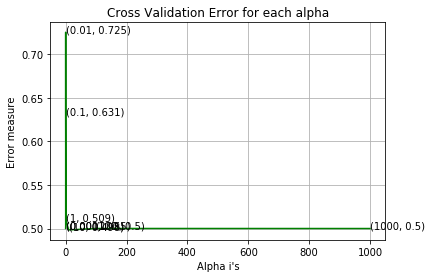

For values of best alpha =  0.01 The train auc score is: 0.8523349281509626
For values of best alpha =  0.01 The test auc score is: 0.7388383948778421


In [42]:
# code copied from Quora question Pair Similarity Problem case study

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
alpha = [10 ** x for x in range(-4,4)] 

auc_score_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', class_weight= 'balanced', random_state=42)
    clf.fit(X_train_bow, y_train_bow)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv=10)
    sig_clf.fit(X_train_bow, y_train_bow)
    predict_y = sig_clf.predict_proba(X_cv_bow)[:,1]
    auc_score_array.append(roc_auc_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The auc score is:",roc_auc_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, auc_score_array,c='g')
for i, txt in enumerate(np.round(auc_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],auc_score_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(auc_score_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', class_weight= 'balanced', random_state=42)
clf.fit(X_train_bow, y_train_bow)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv=10)
sig_clf.fit(X_train_bow, y_train_bow)

predict_y = sig_clf.predict_proba(X_train_bow)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The train auc score is:",roc_auc_score(y_train_bow, predict_y))
predict_y = sig_clf.predict_proba(X_test_bow)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The test auc score is:",roc_auc_score(y_test, predict_y))

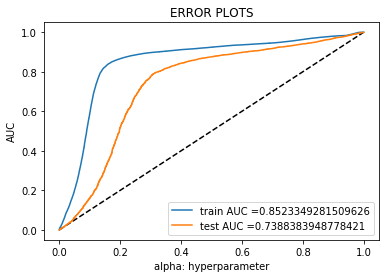

Train confusion matrix
[[38332 16271]
 [ 5643 48960]]
Test confusion matrix
[[ 1680  1801]
 [ 1983 14536]]


In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

predict_y = sig_clf.predict_proba(X_train_bow)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_bow, predict_y)
predict_y = sig_clf.predict_proba(X_test_bow)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_y)

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_bow, sig_clf.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, sig_clf.predict(X_test_bow)))

Confusion matrix for TRAIN data


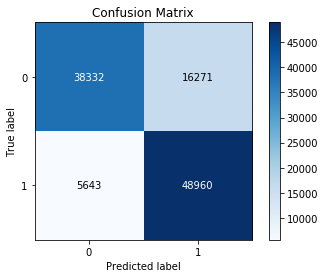

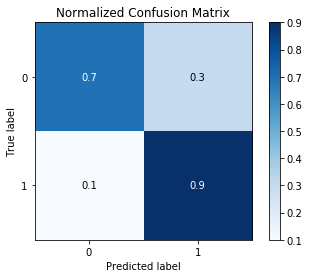

In [44]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_bow, sig_clf.predict(X_train_bow))
skplt.metrics.plot_confusion_matrix(y_train_bow, sig_clf.predict(X_train_bow), normalize=True)

Confusion matrix for TEST data


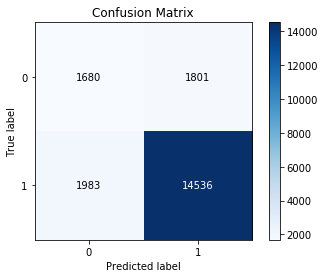

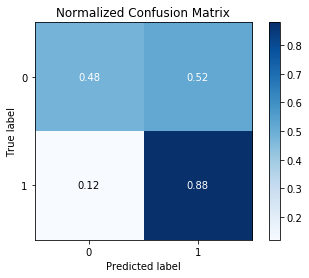

In [45]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(X_test_bow))
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(X_test_bow), normalize=True)

### [4.1.1.2]  Feature Importance 

In [46]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def feature_importance(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_ [0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("The informative features are below: ")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

feature_importance(count_vect, clf)

The informative features are below: 
	-755.9196	already trap   			721.0253	tasted kellogg 
	-755.9196	annoy set      			721.0253	really minimal 
	-755.9196	appeal fly     			721.0253	nut fails      
	-755.9196	dead fly       			721.0253	minimal difference
	-755.9196	den kitchen    			721.0253	like loses     
	-755.9196	died nor       			721.0253	flakes nothing 
	-755.9196	even uglier    			721.0253	fails something
	-755.9196	flies already  			721.0253	bits honey     
	-755.9196	flies flying   			721.0253	added nut      
	-755.9196	flies one      			700.4891	tuna plus      


### [4.1.1.3] Applying Linear SVM on BOW with L2 regularization

For values of alpha =  0.0001 The auc score is: 0.5
For values of alpha =  0.001 The auc score is: 0.5
For values of alpha =  0.01 The auc score is: 0.5
For values of alpha =  0.1 The auc score is: 0.9058783196837102
For values of alpha =  1 The auc score is: 0.863876792821406
For values of alpha =  10 The auc score is: 0.9012853543026079
For values of alpha =  100 The auc score is: 0.8913908056692805
For values of alpha =  1000 The auc score is: 0.9105533467950603
For values of alpha =  10000 The auc score is: 0.9109834029919878
For values of alpha =  100000 The auc score is: 0.9108653659265036


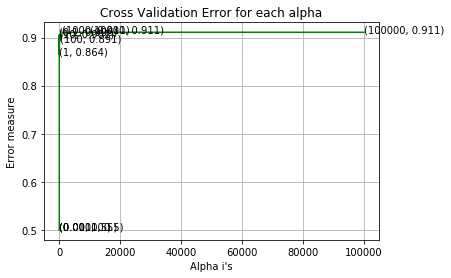

For values of best alpha =  10000 The train auc score is: 0.9999585962322158
For values of best alpha =  10000 The test auc score is: 0.9097063177083264


In [47]:
# code copied from Quora question Pair Similarity Problem case study

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
alpha = [10 ** x for x in range(-4,6)] 

auc_score_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=22, class_weight= 'balanced')
    clf.fit(X_train_bow, y_train_bow)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=10)
    sig_clf.fit(X_train_bow, y_train_bow)
    predict_y = sig_clf.predict_proba(X_cv_bow)[:,1]
    auc_score_array.append(roc_auc_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The auc score is:",roc_auc_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, auc_score_array,c='g')
for i, txt in enumerate(np.round(auc_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],auc_score_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(auc_score_array)
clf = SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='hinge',random_state=22,class_weight='balanced')
clf.fit(X_train_bow, y_train_bow)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=10)
sig_clf.fit(X_train_bow, y_train_bow)

predict_y = sig_clf.predict_proba(X_train_bow)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The train auc score is:",roc_auc_score(y_train_bow, predict_y))
predict_y = sig_clf.predict_proba(X_test_bow)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The test auc score is:",roc_auc_score(y_test, predict_y))

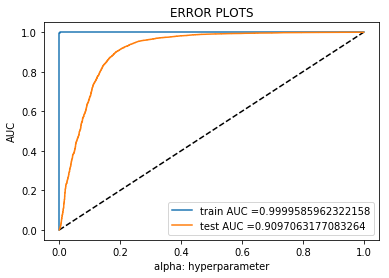

Train confusion matrix
[[54461    71]
 [   44 54488]]
Test confusion matrix
[[ 2048  1387]
 [  294 16271]]


In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

predict_y = sig_clf.predict_proba(X_train_bow)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_bow, predict_y)
predict_y = sig_clf.predict_proba(X_test_bow)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_y)

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_bow, sig_clf.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, sig_clf.predict(X_test_bow)))

Confusion matrix for TRAIN data


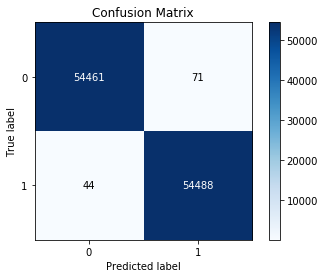

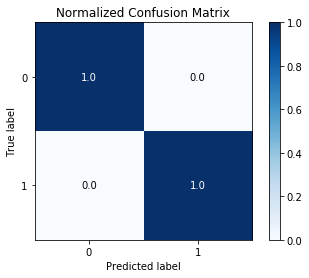

In [49]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_bow, sig_clf.predict(X_train_bow))
skplt.metrics.plot_confusion_matrix(y_train_bow, sig_clf.predict(X_train_bow), normalize=True)

Confusion matrix for TEST data


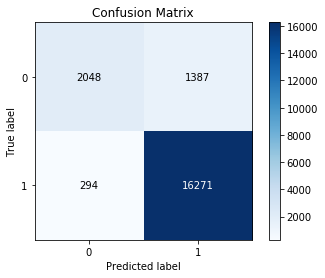

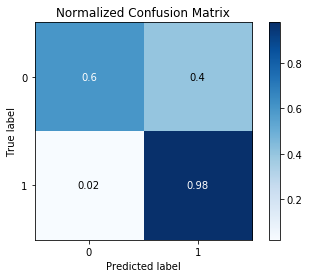

In [50]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(X_test_bow))
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(X_test_bow), normalize=True)

### [4.1.1.4]  Feature Importance 

In [51]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def feature_importance(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_ [0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("The informative features are below: ")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

feature_importance(count_vect, clf)

The informative features are below: 
	-0.0001	disappointed   			0.0000	great          
	-0.0001	salty          			0.0000	best           
	-0.0000	beware         			0.0000	love           
	-0.0000	not good       			0.0000	good           
	-0.0000	waste money    			0.0000	delicious      
	-0.0000	worst          			0.0000	favorite       
	-0.0000	not buy        			0.0000	excellent      
	-0.0000	terrible       			0.0000	perfect        
	-0.0000	horrible       			0.0000	find           
	-0.0000	not worth      			0.0000	loves          


### [4.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [52]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_tr = tf_idf_vect.fit_transform(X_tr['FinalReview'].values)
print("The shape of train TFIDF vectorizer ",tf_idf_tr.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_train_tfidf = hstack((tf_idf_tr,np.array(X_tr['word_count'])[:,None]))
print("The shape of train text BOW after adding word_count ",final_train_tfidf.get_shape())

# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
x_scaled_tr = scaler.fit_transform(final_train_tfidf)

The shape of train TFIDF vectorizer  (64000, 1176064)
The shape of train text BOW after adding word_count  (64000, 1176065)


In [53]:
# Balancing the train data
from imblearn.over_sampling import SMOTE 
from collections import Counter

sm = SMOTE(random_state=2)
X_train_tfidf, y_train_tfidf = sm.fit_resample(x_scaled_tr, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_tfidf))

Resampled dataset shape Counter({0: 54532, 1: 54532})


In [54]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_tfidf).items()))

Train data before upsampling:  [(0, 9468), (1, 54532)]
Train data after upsampling :  [(0, 54532), (1, 54532)]


In [56]:
#BoW: 
tf_idf_cv = tf_idf_vect.transform(X_cv['FinalReview'].values)
print("The shape of cv text TFIDF vectorizer ",tf_idf_cv.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_cv_tfidf = hstack((tf_idf_cv,np.array(X_cv['word_count'])[:,None]))
print("The shape of cv text TFIDF after adding word_count ",final_cv_tfidf.get_shape())

# Data-preprocessing: Standardizing the data

X_cv_tfidf = scaler.transform(final_cv_tfidf)

The shape of cv text TFIDF vectorizer  (16000, 1176064)
The shape of cv text TFIDF after adding word_count  (16000, 1176065)


In [57]:
tf_idf_test = tf_idf_vect.transform(X_test['FinalReview'].values)
print("The shape of test TFIDF vectorizer ",tf_idf_test.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_test_tfidf = hstack((tf_idf_test,np.array(X_test['word_count'])[:,None]))
print("The shape of test text BOW after adding word_count ",final_test_tfidf.get_shape())

# Data-preprocessing: Standardizing the data

X_test_tfidf = scaler.transform(final_test_tfidf)

The shape of test TFIDF vectorizer  (20000, 1176064)
The shape of test text BOW after adding word_count  (20000, 1176065)


### [4.1.2.1] Applying Linear SVM on TFIDF with L1 regularization

For values of alpha =  1e-06 The auc score is: 0.8618201478961982
For values of alpha =  1e-05 The auc score is: 0.86810814610252
For values of alpha =  0.0001 The auc score is: 0.868298331577586
For values of alpha =  0.001 The auc score is: 0.8754856999822087
For values of alpha =  0.01 The auc score is: 0.8128695414382605
For values of alpha =  0.1 The auc score is: 0.6446917041641537
For values of alpha =  1 The auc score is: 0.5756814142427631
For values of alpha =  10 The auc score is: 0.5030851519443135
For values of alpha =  100 The auc score is: 0.5000964439547779
For values of alpha =  1000 The auc score is: 0.5


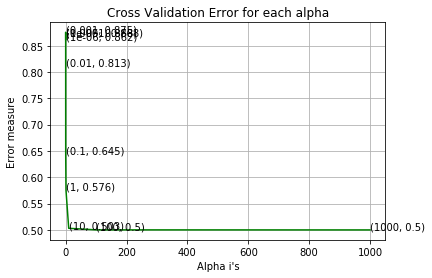

For values of best alpha =  0.001 The train auc score is: 0.9971387231928124
For values of best alpha =  0.001 The test auc score is: 0.8754623465146125


In [58]:
# code copied from Quora question Pair Similarity Problem case study

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
alpha = [10 ** x for x in range(-6,4)] 

auc_score_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42, class_weight= 'balanced')
    clf.fit(X_train_tfidf, y_train_tfidf)
    sig_clf = CalibratedClassifierCV(clf, method="isotonic",cv=10)
    sig_clf.fit(X_train_tfidf, y_train_tfidf)
    predict_y = sig_clf.predict_proba(X_cv_tfidf)[:,1]
    auc_score_array.append(roc_auc_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The auc score is:",roc_auc_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, auc_score_array,c='g')
for i, txt in enumerate(np.round(auc_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],auc_score_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(auc_score_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42, class_weight= 'balanced')
clf.fit(X_train_tfidf, y_train_tfidf)
sig_clf = CalibratedClassifierCV(clf, method="isotonic",cv=10)
sig_clf.fit(X_train_tfidf, y_train_tfidf)

predict_y = sig_clf.predict_proba(X_train_tfidf)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The train auc score is:",roc_auc_score(y_train_tfidf, predict_y))
predict_y = sig_clf.predict_proba(X_test_tfidf)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The test auc score is:",roc_auc_score(y_test, predict_y))

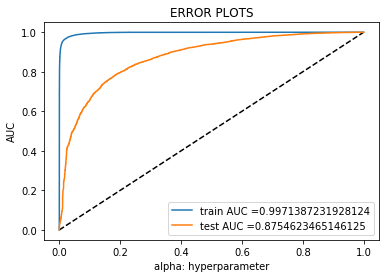

Train confusion matrix
[[50850  3682]
 [  573 53959]]
Test confusion matrix
[[ 1549  1886]
 [  820 15745]]


In [59]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

predict_y = sig_clf.predict_proba(X_train_tfidf)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf, predict_y)
predict_y = sig_clf.predict_proba(X_test_tfidf)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_y)

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf, sig_clf.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, sig_clf.predict(X_test_tfidf)))

Confusion matrix for TRAIN data


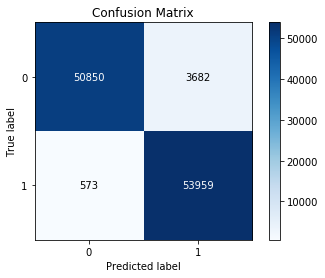

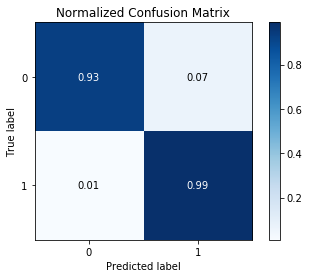

In [60]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_tfidf, sig_clf.predict(X_train_tfidf))
skplt.metrics.plot_confusion_matrix(y_train_tfidf, sig_clf.predict(X_train_tfidf), normalize=True)

Confusion matrix for TEST data


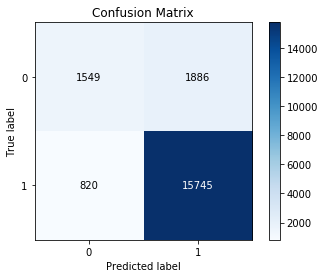

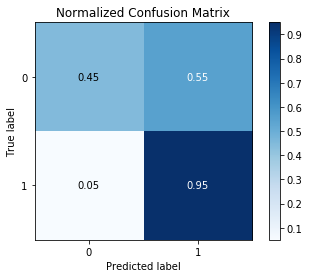

In [61]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(X_test_tfidf))
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(X_test_tfidf), normalize=True)

### [4.1.2.2]  Feature Importance

In [62]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def feature_importance(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_ [0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("The informative features are below: ")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

feature_importance(tf_idf_vect, clf)

The informative features are below: 
	-1290.4911	acesuflamek    			1391.1027	drive cups     
	-1290.4911	acesuflamek sacharin			1346.1827	terms shells   
	-1290.4911	acesulfame although			1346.1827	shells seeds   
	-1290.4911	address boxes  			1346.1827	seem identical 
	-1290.4911	agent orange   			1346.1827	quality economical
	-1290.4911	allow called   			1346.1827	purchased divided
	-1290.4911	although stevia			1346.1827	probably economical
	-1290.4911	answer company 			1346.1827	identical terms
	-1290.4911	aspartame equal			1346.1827	frig quality   
	-1290.4911	blew cover     			1346.1827	economical health


### [4.1.2.3] Applying Linear SVM on TFIDF with L2 regularization

For values of alpha =  1e-06 The auc score is: 0.5
For values of alpha =  1e-05 The auc score is: 0.5
For values of alpha =  0.0001 The auc score is: 0.5
For values of alpha =  0.001 The auc score is: 0.5
For values of alpha =  0.01 The auc score is: 0.5
For values of alpha =  0.1 The auc score is: 0.8754163199201535
For values of alpha =  1 The auc score is: 0.8998618831871241
For values of alpha =  10 The auc score is: 0.9144958691509166
For values of alpha =  100 The auc score is: 0.8898098287621499
For values of alpha =  1000 The auc score is: 0.9016201266141971
For values of alpha =  10000 The auc score is: 0.9015956860603209
For values of alpha =  100000 The auc score is: 0.9015956860603209


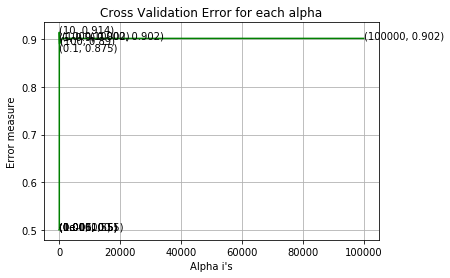

For values of best alpha =  10 The train auc score is: 0.9999989013830826
For values of best alpha =  10 The test auc score is: 0.9097894712330369


In [63]:
# code copied from Quora question Pair Similarity Problem case study

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
alpha = [10 ** x for x in range(-6,6)] 

auc_score_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42, class_weight= 'balanced')
    clf.fit(X_train_tfidf, y_train_tfidf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=10)
    sig_clf.fit(X_train_tfidf, y_train_tfidf)
    predict_y = sig_clf.predict_proba(X_cv_tfidf)[:,1]
    auc_score_array.append(roc_auc_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The auc score is:",roc_auc_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, auc_score_array,c='g')
for i, txt in enumerate(np.round(auc_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],auc_score_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(auc_score_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42, class_weight= 'balanced')
clf.fit(X_train_tfidf, y_train_tfidf)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=10)
sig_clf.fit(X_train_tfidf, y_train_tfidf)

predict_y = sig_clf.predict_proba(X_train_tfidf)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The train auc score is:",roc_auc_score(y_train_tfidf, predict_y))
predict_y = sig_clf.predict_proba(X_test_tfidf)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The test auc score is:",roc_auc_score(y_test, predict_y))

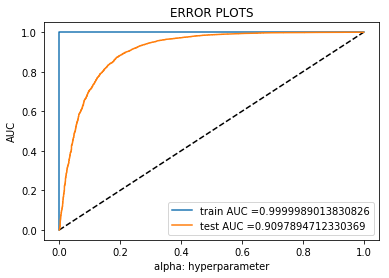

Train confusion matrix
[[54462    70]
 [    0 54532]]
Test confusion matrix
[[  597  2838]
 [   19 16546]]


In [64]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

predict_y = sig_clf.predict_proba(X_train_tfidf)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf, predict_y)
predict_y = sig_clf.predict_proba(X_test_tfidf)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_y)

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf, sig_clf.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, sig_clf.predict(X_test_tfidf)))

Confusion matrix for TRAIN data


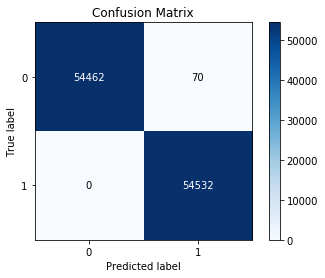

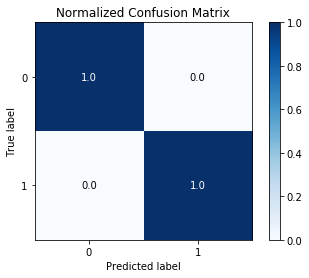

In [65]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_tfidf, sig_clf.predict(X_train_tfidf))
skplt.metrics.plot_confusion_matrix(y_train_tfidf, sig_clf.predict(X_train_tfidf), normalize=True)

Confusion matrix for TEST data


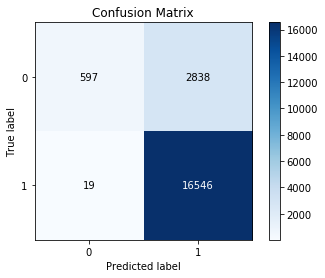

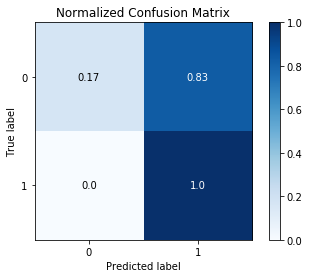

In [66]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(X_test_tfidf))
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(X_test_tfidf), normalize=True)

### [4.1.2.4]  Feature Importance

In [67]:
#https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def feature_importance(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_ [0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("The informative features are below: ")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

feature_importance(tf_idf_vect, clf)

The informative features are below: 
	-0.0236	disappointed   			0.0175	great          
	-0.0226	salty          			0.0124	love           
	-0.0140	not good       			0.0115	best           
	-0.0137	coffee not     			0.0109	good           
	-0.0045	not buy        			0.0089	delicious      
	-0.0045	terrible       			0.0077	excellent      
	-0.0044	worst          			0.0073	favorite       
	-0.0043	horrible       			0.0070	loves          
	-0.0040	waste money    			0.0069	find           
	-0.0040	not worth      			0.0069	price          


## Word2Vec 

In [70]:
# Train the Word2Vec model using text corpus
i=0
list_of_sent_train=[]
list_of_sent_cv=[]
list_of_sent_test=[]
for sent in X_tr['FinalReview'].values:
    list_of_sent_train.append(sent.split())
    
for sent in X_cv['FinalReview'].values:
    list_of_sent_cv.append(sent.split())
    
for sent in X_test['FinalReview'].values:
    list_of_sent_test.append(sent.split())

In [71]:
# Train data
print(X_tr['FinalReview'].values[0])
print("*****************************************************************")
print(list_of_sent_train[0])
print("*****************************************************************")

# CV data
print(X_cv['FinalReview'].values[0])
print("*****************************************************************")
print(list_of_sent_cv[0])
print("*****************************************************************")

# Test data
print(X_test['FinalReview'].values[0])
print("*****************************************************************")
print(list_of_sent_test[0])

witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college every book educational
*****************************************************************
['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'recite', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'whales', 'india', 'drooping', 'roses', 'love', 'new', 'words', 'book', 'introduces', 'silliness', 'classic', 'book', 'willing', 'bet', 'son', 'still', 'able', 'recite', 'memory', 'college', 'every', 'book', 'educational']
*****************************************************************
year old boys thrilled tasty snack low sugar content gluten free dairy free house make snacking easy agree previous review sticking however not last long enough house problem gluten free
*****************************************************************
['year',

In [88]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)

In [89]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("Number of words that occured minimum 5 times in the train data: ",len(w2v_words_train))
print("Sample words in train data: ", w2v_words_train[0:50])

Number of words that occured minimum 5 times in the train data:  15898
Sample words in train data:  ['distribution', 'mates', 'appetites', 'molly', 'alexander', 'fans', 'cob', 'colours', 'chocolaty', 'benecol', 'pawn', 'bagged', 'palates', 'dreadful', 'conditioned', 'nondescript', 'finest', 'seattle', 'monde', 'delallo', 'combining', 'slathered', 'remain', 'martinis', 'domain', 'apricot', 'postum', 'padded', 'para', 'judgement', 'trace', 'solidified', 'lox', 'gaba', 'prone', 'populated', 'treating', 'chills', 'rainbow', 'format', 'jumbone', 'stimulants', 'figs', 'clearing', 'phenomenon', 'euphoric', 'schools', 'copper', 'especially', 'irritated']


In [90]:
w2v_model_train.wv.most_similar('taste')

[('flavor', 0.826150119304657),
 ('tastes', 0.8230266571044922),
 ('aftertaste', 0.755672037601471),
 ('tasting', 0.7544400095939636),
 ('sounds', 0.6459454894065857),
 ('overly', 0.6272404789924622),
 ('smell', 0.6150791049003601),
 ('hint', 0.6138055324554443),
 ('tasted', 0.6130914092063904),
 ('flavour', 0.6106137633323669)]

### [4.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [76]:
# average Word2Vec for train data
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 64000/64000 [36:02<00:00, 29.60it/s]  

64000
50


In [77]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_w2v, y_train_w2v = sm.fit_resample(sent_vectors_train, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_w2v))

Resampled dataset shape Counter({0: 54532, 1: 54532})


In [78]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_w2v).items()))

Train data before upsampling:  [(0, 9468), (1, 54532)]
Train data after upsampling :  [(0, 54532), (1, 54532)]


In [92]:
# average Word2Vec for test data
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

20000
50


In [95]:
# average Word2Vec for cv data
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

16000
50


In [96]:
# Data-preprocessing: Standardizing both train and test data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_data_train = scaler.fit_transform(X_train_w2v)
standardized_data_cv = scaler.transform(sent_vectors_cv)
standardized_data_test = scaler.transform(sent_vectors_test)

### [4.1.3.1] Applying Linear SVM on AVG W2V with L1 regularization

For values of alpha =  0.0001 The auc score is: 0.8824377192992632
For values of alpha =  0.001 The auc score is: 0.9006952085230091
For values of alpha =  0.01 The auc score is: 0.9085665696883768
For values of alpha =  0.1 The auc score is: 0.8732846923248013
For values of alpha =  1 The auc score is: 0.5
For values of alpha =  10 The auc score is: 0.5
For values of alpha =  100 The auc score is: 0.5
For values of alpha =  1000 The auc score is: 0.5


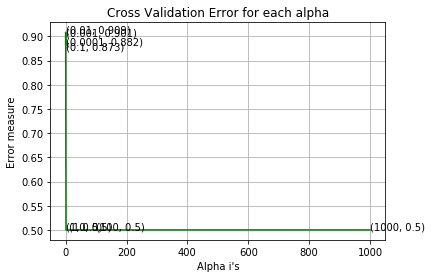

For values of best alpha =  0.01 The train auc score is: 0.9388397002789576
For values of best alpha =  0.01 The test auc score is: 0.9076830851600879


In [97]:
# code copied from Quora question Pair Similarity Problem case study

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
alpha = [10 ** x for x in range(-4,4)] 

auc_score_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42, class_weight= 'balanced')
    clf.fit(standardized_data_train, y_train_w2v)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(standardized_data_train, y_train_w2v)
    predict_y = sig_clf.predict_proba(standardized_data_cv)[:,1]
    auc_score_array.append(roc_auc_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The auc score is:",roc_auc_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, auc_score_array,c='g')
for i, txt in enumerate(np.round(auc_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],auc_score_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(auc_score_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42, class_weight= 'balanced')
clf.fit(standardized_data_train, y_train_w2v)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(standardized_data_train, y_train_w2v)

predict_y = sig_clf.predict_proba(standardized_data_train)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The train auc score is:",roc_auc_score(y_train_w2v, predict_y))
predict_y = sig_clf.predict_proba(standardized_data_test)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The test auc score is:",roc_auc_score(y_test, predict_y))

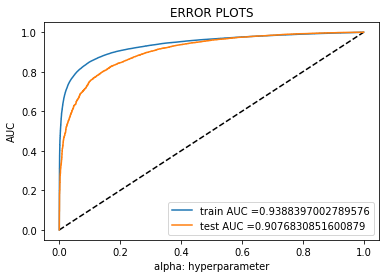

Train confusion matrix
[[49216  5316]
 [ 8298 46234]]
Test confusion matrix
[[ 3269   166]
 [ 6143 10422]]


In [98]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

predict_y = sig_clf.predict_proba(standardized_data_train)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_w2v, predict_y)
predict_y = sig_clf.predict_proba(standardized_data_test)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_y)

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_w2v, sig_clf.predict(standardized_data_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, sig_clf.predict(standardized_data_test)))

Confusion matrix for TRAIN data


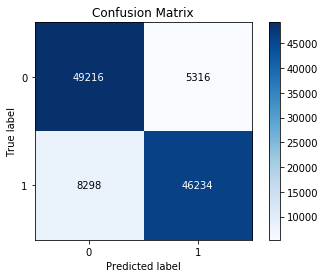

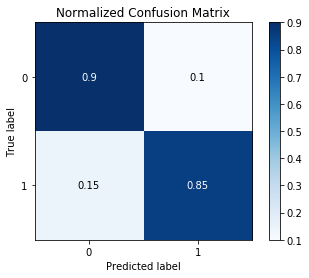

In [99]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_w2v, sig_clf.predict(standardized_data_train))
skplt.metrics.plot_confusion_matrix(y_train_w2v, sig_clf.predict(standardized_data_train), normalize=True)

Confusion matrix for TEST data


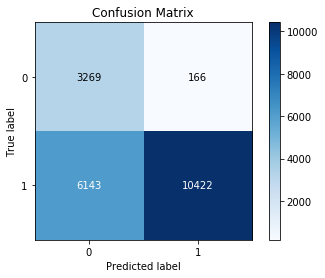

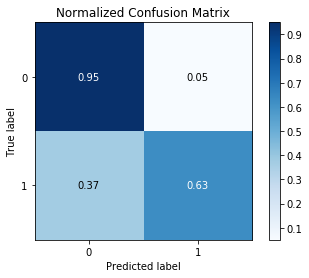

In [100]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(standardized_data_test))
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(standardized_data_test), normalize=True)

### [4.1.3.2] Applying Linear SVM on AVG W2V with L2 regularization

For values of alpha =  0.0001 The auc score is: 0.8781592250145562
For values of alpha =  0.001 The auc score is: 0.8970784811231919
For values of alpha =  0.01 The auc score is: 0.9043172880613773
For values of alpha =  0.1 The auc score is: 0.9101537556035307
For values of alpha =  1 The auc score is: 0.9152847691003061
For values of alpha =  10 The auc score is: 0.9144428223392673
For values of alpha =  100 The auc score is: 0.9143969468659722
For values of alpha =  1000 The auc score is: 0.9143969468659722


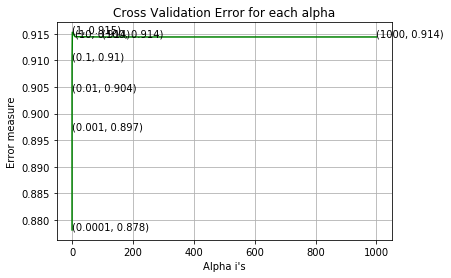

For values of best alpha =  1 The train auc score is: 0.9295508115173459
For values of best alpha =  1 The test auc score is: 0.9111650236749851


In [101]:
# code copied from Quora question Pair Similarity Problem case study

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
alpha = [10 ** x for x in range(-4,4)] 

auc_score_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42, class_weight= 'balanced')
    clf.fit(standardized_data_train, y_train_w2v)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(standardized_data_train, y_train_w2v)
    predict_y = sig_clf.predict_proba(standardized_data_cv)[:,1]
    auc_score_array.append(roc_auc_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The auc score is:",roc_auc_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, auc_score_array,c='g')
for i, txt in enumerate(np.round(auc_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],auc_score_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(auc_score_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42, class_weight= 'balanced')
clf.fit(standardized_data_train, y_train_w2v)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(standardized_data_train, y_train_w2v)

predict_y = sig_clf.predict_proba(standardized_data_train)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The train auc score is:",roc_auc_score(y_train_w2v, predict_y))
predict_y = sig_clf.predict_proba(standardized_data_test)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The test auc score is:",roc_auc_score(y_test, predict_y))

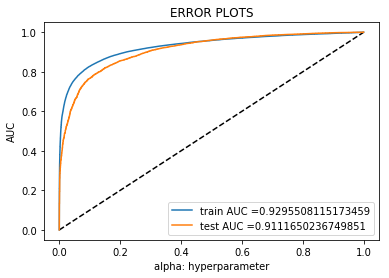

Train confusion matrix
[[48599  5933]
 [ 8974 45558]]
Test confusion matrix
[[ 3188   247]
 [ 4617 11948]]


In [102]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

predict_y = sig_clf.predict_proba(standardized_data_train)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_w2v, predict_y)
predict_y = sig_clf.predict_proba(standardized_data_test)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_y)

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_w2v, sig_clf.predict(standardized_data_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, sig_clf.predict(standardized_data_test)))

Confusion matrix for TRAIN data


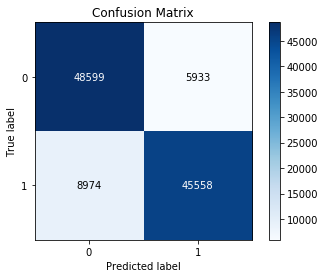

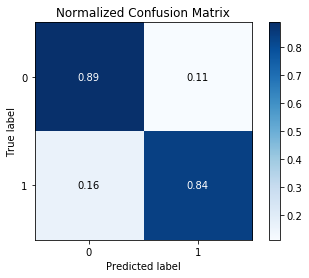

In [104]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_w2v, sig_clf.predict(standardized_data_train))
skplt.metrics.plot_confusion_matrix(y_train_w2v, sig_clf.predict(standardized_data_train), normalize=True)

Confusion matrix for TEST data


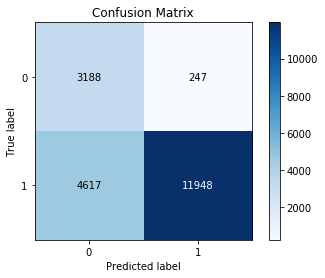

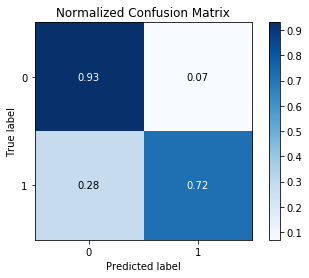

In [105]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(standardized_data_test))
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(standardized_data_test), normalize=True)

### [4.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [106]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_tr['FinalReview'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model.get_feature_names(), list(model.idf_)))

In [107]:
tf_idf_matrix_cv = model.transform(X_cv['FinalReview'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary_cv = dict(zip(model.get_feature_names(), list(model.idf_)))

In [108]:
tf_idf_matrix_test = model.transform(X_test['FinalReview'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary_test = dict(zip(model.get_feature_names(), list(model.idf_)))

In [110]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_train = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf_train)
            weight_sum += tf_idf_train
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [111]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_tfidf_w2v, y_train_tfidf_w2v = sm.fit_resample(tfidf_sent_vectors_train, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_tfidf_w2v))

Resampled dataset shape Counter({0: 54532, 1: 54532})


In [112]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_tfidf_w2v).items()))

Train data before upsampling:  [(0, 9468), (1, 54532)]
Train data after upsampling :  [(0, 54532), (1, 54532)]


In [114]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_cv = dictionary_cv[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf_cv)
            weight_sum += tf_idf_cv
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

In [116]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_test = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf_test)
            weight_sum += tf_idf_test
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [117]:
# Data-preprocessing: Standardizing both train and test data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_data_train = scaler.fit_transform(X_train_tfidf_w2v)
standardized_data_cv = scaler.transform(tfidf_sent_vectors_cv)
standardized_data_test = scaler.transform(tfidf_sent_vectors_test)

### [4.1.4.1] Applying Linear SVM on TFIDF W2V with L1 regularization

For values of alpha =  0.0001 The auc score is: 0.9084023407670231
For values of alpha =  0.001 The auc score is: 0.9154127722168853
For values of alpha =  0.01 The auc score is: 0.9114296474306414
For values of alpha =  0.1 The auc score is: 0.8692677409683057
For values of alpha =  1 The auc score is: 0.5
For values of alpha =  10 The auc score is: 0.5
For values of alpha =  100 The auc score is: 0.5
For values of alpha =  1000 The auc score is: 0.5


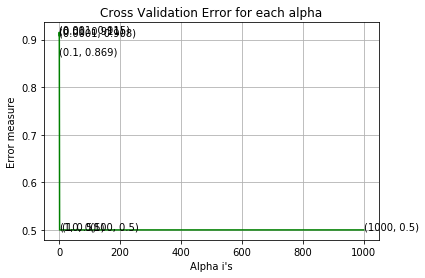

For values of best alpha =  0.001 The train auc score is: 0.9197429293311115
For values of best alpha =  0.001 The test auc score is: 0.9096395259994262


In [118]:
# code copied from Quora question Pair Similarity Problem case study

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
alpha = [10 ** x for x in range(-4,4)] 

auc_score_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42, class_weight= 'balanced')
    clf.fit(standardized_data_train, y_train_tfidf_w2v)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(standardized_data_train, y_train_tfidf_w2v)
    predict_y = sig_clf.predict_proba(standardized_data_cv)[:,1]
    auc_score_array.append(roc_auc_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The auc score is:",roc_auc_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, auc_score_array,c='g')
for i, txt in enumerate(np.round(auc_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],auc_score_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(auc_score_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42, class_weight= 'balanced')
clf.fit(standardized_data_train, y_train_tfidf_w2v)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(standardized_data_train, y_train_tfidf_w2v)

predict_y = sig_clf.predict_proba(standardized_data_train)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The train auc score is:",roc_auc_score(y_train_tfidf_w2v, predict_y))
predict_y = sig_clf.predict_proba(standardized_data_test)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The test auc score is:",roc_auc_score(y_test, predict_y))

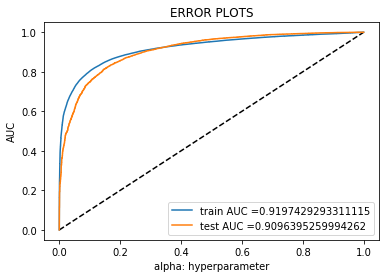

Train confusion matrix
[[47817  6715]
 [ 9493 45039]]
Test confusion matrix
[[ 2928   507]
 [ 3079 13486]]


In [119]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

predict_y = sig_clf.predict_proba(standardized_data_train)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf_w2v, predict_y)
predict_y = sig_clf.predict_proba(standardized_data_test)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_y)

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf_w2v, sig_clf.predict(standardized_data_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, sig_clf.predict(standardized_data_test)))

Confusion matrix for TRAIN data


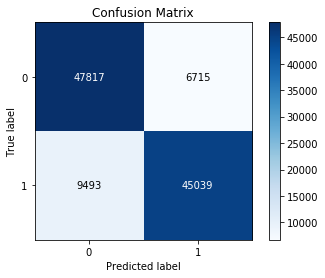

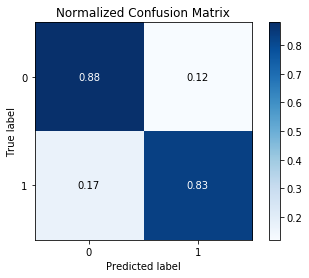

In [120]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_tfidf_w2v, sig_clf.predict(standardized_data_train))
skplt.metrics.plot_confusion_matrix(y_train_tfidf_w2v, sig_clf.predict(standardized_data_train), normalize=True)

Confusion matrix for TEST data


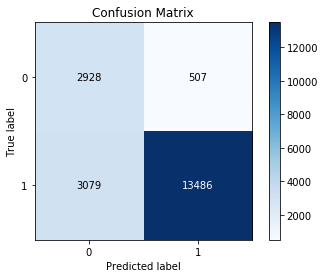

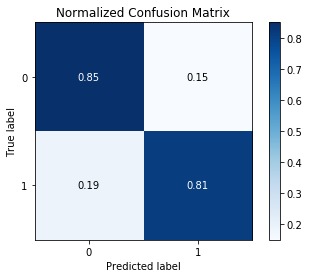

In [121]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(standardized_data_test))
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(standardized_data_test), normalize=True)

### [4.1.4.2] Applying Linear SVM on TFIDF W2V with L2 regularization

For values of alpha =  0.0001 The auc score is: 0.9067634263009466
For values of alpha =  0.001 The auc score is: 0.9150860017479083
For values of alpha =  0.01 The auc score is: 0.9148181048029934
For values of alpha =  0.1 The auc score is: 0.9094403128981476
For values of alpha =  1 The auc score is: 0.897341526868632
For values of alpha =  10 The auc score is: 0.8836059355902027
For values of alpha =  100 The auc score is: 0.883243519351171
For values of alpha =  1000 The auc score is: 0.883243519351171


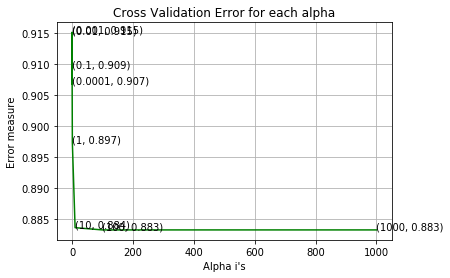

For values of best alpha =  0.001 The train auc score is: 0.9198436856508765
For values of best alpha =  0.001 The test auc score is: 0.9101269534553791


In [122]:
# code copied from Quora question Pair Similarity Problem case study

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
alpha = [10 ** x for x in range(-4,4)] 

auc_score_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42, class_weight= 'balanced')
    clf.fit(standardized_data_train, y_train_tfidf_w2v)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(standardized_data_train, y_train_tfidf_w2v)
    predict_y = sig_clf.predict_proba(standardized_data_cv)[:,1]
    auc_score_array.append(roc_auc_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The auc score is:",roc_auc_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, auc_score_array,c='g')
for i, txt in enumerate(np.round(auc_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],auc_score_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(auc_score_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42, class_weight= 'balanced')
clf.fit(standardized_data_train, y_train_tfidf_w2v)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(standardized_data_train, y_train_tfidf_w2v)

predict_y = sig_clf.predict_proba(standardized_data_train)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The train auc score is:",roc_auc_score(y_train_tfidf_w2v, predict_y))
predict_y = sig_clf.predict_proba(standardized_data_test)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The test auc score is:",roc_auc_score(y_test, predict_y))

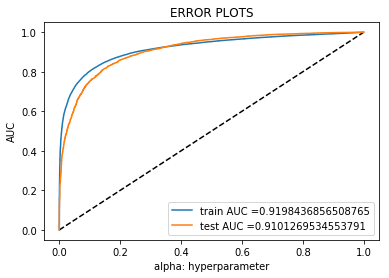

Train confusion matrix
[[47810  6722]
 [ 9506 45026]]
Test confusion matrix
[[ 2930   505]
 [ 3082 13483]]


In [123]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

predict_y = sig_clf.predict_proba(standardized_data_train)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf_w2v, predict_y)
predict_y = sig_clf.predict_proba(standardized_data_test)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_y)

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf_w2v, sig_clf.predict(standardized_data_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, sig_clf.predict(standardized_data_test)))

Confusion matrix for TRAIN data


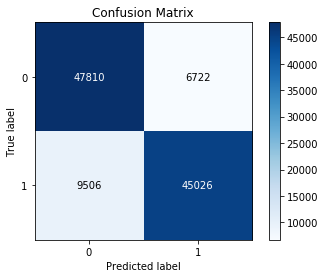

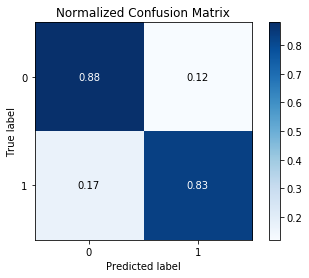

In [124]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_tfidf_w2v, sig_clf.predict(standardized_data_train))
skplt.metrics.plot_confusion_matrix(y_train_tfidf_w2v, sig_clf.predict(standardized_data_train), normalize=True)

Confusion matrix for TEST data


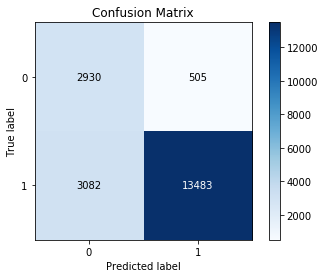

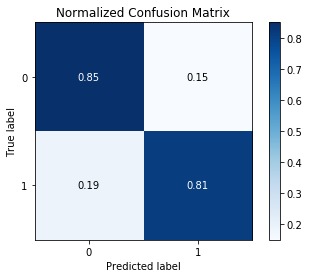

In [125]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(standardized_data_test))
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(standardized_data_test), normalize=True)

## [4.2] RBF SVM

In [32]:
# Taking 20k points from our dataset

final_sample = final_data.sample(n=20000)
print(final_sample.shape)
print(final_sample["Score"].shape)

(20000, 13)
(20000,)


In [33]:
word_count= []
for sentence in final_sample['FinalReview'].values:
    total_words= len(sentence.split())
    word_count.append(total_words)
    
print(final_sample['FinalReview'].values[12])
print("The number of words in the above review is: ", word_count[12])

tasty healthy low fat natural great product always stock office thanks great snack
The number of words in the above review is:  13


In [34]:
final_sample['word_count']=word_count 
print(final_sample['FinalReview'].values[5])
print("*"*100)
print(final_sample['word_count'].values[5])

toddler cannot drink cow milk related products not happy drinking much soy everyday since new research shows breaks estrogen like components drinks lot almond milk protein non dairy milk substitutes tastes good also adequaate amount calcium even fiber good around nutrition perfect milk substitute
****************************************************************************************************
44


In [35]:
# Sorting the data based on time

final_sample.sort_values(by='Time', ascending=True, inplace=True)
print(final_sample['Time'].head(1))
print(final_sample['Time'].tail(1))

138706    939340800
Name: Time, dtype: int64
429396    1351209600
Name: Time, dtype: int64


In [36]:
import sklearn.model_selection as model_selection

# split the data set into train and test
X_1, X_test, y_1, y_test = model_selection.train_test_split(final_sample, final_sample["Score"], shuffle=False,test_size=0.2)
X_tr, X_cv, y_tr, y_cv = model_selection.train_test_split(X_1, y_1, shuffle=False,test_size=0.2)

print("No of data points in training dataset", X_tr.shape)
print("No of data points in cv dataset", X_cv.shape)
print("No of data points in test dataset", X_test.shape)

No of data points in training dataset (12800, 14)
No of data points in cv dataset (3200, 14)
No of data points in test dataset (4000, 14)


In [37]:
print(X_tr['Time'].head(1))
print(X_tr['Time'].tail(1))

print('********************************')

print(X_cv['Time'].head(1))
print(X_cv['Time'].tail(1))

print('********************************')

print(X_test['Time'].head(1))
print(X_test['Time'].tail(1))

138706    939340800
Name: Time, dtype: int64
52871    1325203200
Name: Time, dtype: int64
********************************
86530    1325203200
Name: Time, dtype: int64
86245    1337126400
Name: Time, dtype: int64
********************************
406471    1337126400
Name: Time, dtype: int64
429396    1351209600
Name: Time, dtype: int64


### [4.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [132]:
#BoW: 
count_vect = CountVectorizer(min_df=10, max_features=500) 
final_counts_train = count_vect.fit_transform(X_tr['FinalReview'].values)
print("The shape of train text BOW vectorizer ",final_counts_train.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_train = hstack((final_counts_train,np.array(X_tr['word_count'])[:,None]))
print("The shape of train text BOW after adding word_count ",final_train.get_shape())

The shape of train text BOW vectorizer  (12800, 500)
The shape of train text BOW after adding word_count  (12800, 501)


In [133]:
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
standardized_data_train = scaler.fit_transform(final_train)

# Converting sparse matrices to dense
standardized_data_train_dense =standardized_data_train.toarray()

In [134]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_bow, y_train_bow = sm.fit_resample(standardized_data_train_dense, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_bow))

Resampled dataset shape Counter({0: 10879, 1: 10879})


In [135]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_bow).items()))

Train data before upsampling:  [(0, 1921), (1, 10879)]
Train data after upsampling :  [(0, 10879), (1, 10879)]


In [136]:
#BoW: 
final_counts_cv = count_vect.transform(X_cv['FinalReview'].values)
print("The shape of cv text BOW vectorizer ",final_counts_cv.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_cv = hstack((final_counts_cv,np.array(X_cv['word_count'])[:,None]))
print("The shape of cv text BOW after adding word_count ",final_cv.get_shape())

# Data-preprocessing: Standardizing the data
standardized_data_cv = scaler.transform(final_cv)

# Converting sparse matrices to dense
X_cv_bow =standardized_data_cv.toarray()

The shape of cv text BOW vectorizer  (3200, 500)
The shape of cv text BOW after adding word_count  (3200, 501)


In [137]:
#BoW: 
final_counts_test = count_vect.transform(X_test['FinalReview'].values)
print("The shape of test text BOW vectorizer ",final_counts_test.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_test = hstack((final_counts_test,np.array(X_test['word_count'])[:,None]))
print("The shape of train text BOW after adding word_count ",final_test.get_shape())

# Data-preprocessing: Standardizing the data
standardized_data_test = scaler.transform(final_test)

# Converting sparse matrices to dense
X_test_bow =standardized_data_test.toarray()

The shape of test text BOW vectorizer  (4000, 500)
The shape of train text BOW after adding word_count  (4000, 501)


For values of alpha =  0.0001 The auc score is: 0.5095654915860396
For values of alpha =  0.001 The auc score is: 0.5095654915860396
For values of alpha =  0.01 The auc score is: 0.618990883545678
For values of alpha =  0.1 The auc score is: 0.8555656672095028
For values of alpha =  1 The auc score is: 0.9045732615938096
For values of alpha =  10 The auc score is: 0.9002970963587402
For values of alpha =  100 The auc score is: 0.8825657789698886
For values of alpha =  1000 The auc score is: 0.8743726783110345


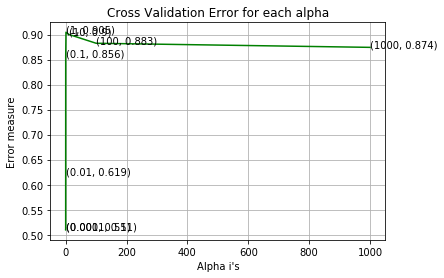

For values of best alpha =  1 The train auc score is: 0.992295440200612
For values of best alpha =  1 The test auc score is: 0.8830497534548071


In [140]:
# code copied from Quora question Pair Similarity Problem case study

from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
alpha = [10 ** x for x in range(-4,4)] 

auc_score_array=[]

for i in alpha:
    clf = SVC(C=i, kernel='rbf', random_state=42, class_weight= 'balanced')
    clf.fit(X_train_bow, y_train_bow)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv =10)
    sig_clf.fit(X_train_bow, y_train_bow)
    predict_y = sig_clf.predict_proba(X_cv_bow)[:,1]
    auc_score_array.append(roc_auc_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The auc score is:",roc_auc_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, auc_score_array,c='g')
for i, txt in enumerate(np.round(auc_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],auc_score_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(auc_score_array)
clf = SVC(C=alpha[best_alpha], kernel='rbf', random_state=42, class_weight= 'balanced')
clf.fit(X_train_bow, y_train_bow)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_bow, y_train_bow)

predict_y = sig_clf.predict_proba(X_train_bow)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The train auc score is:",roc_auc_score(y_train_bow, predict_y))
predict_y = sig_clf.predict_proba(X_test_bow)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The test auc score is:",roc_auc_score(y_test, predict_y))

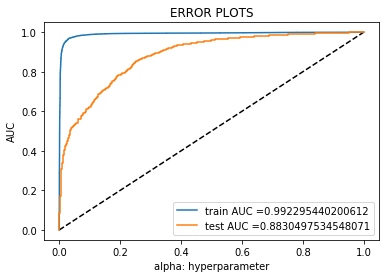

Train confusion matrix
[[10551   328]
 [  364 10515]]
Test confusion matrix
[[ 374  310]
 [ 170 3146]]


In [141]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

predict_y = sig_clf.predict_proba(X_train_bow)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_bow, predict_y)
predict_y = sig_clf.predict_proba(X_test_bow)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_y)

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_bow, sig_clf.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, sig_clf.predict(X_test_bow)))

Confusion matrix for TRAIN data


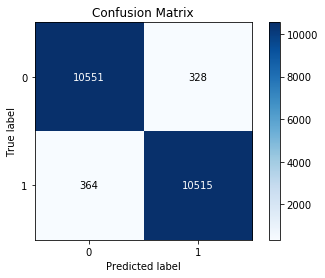

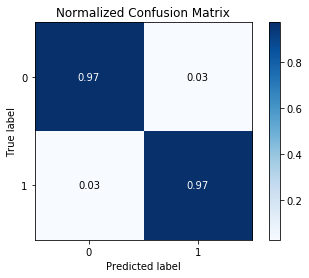

In [142]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_bow, sig_clf.predict(X_train_bow))
skplt.metrics.plot_confusion_matrix(y_train_bow, sig_clf.predict(X_train_bow), normalize=True)

Confusion matrix for TEST data


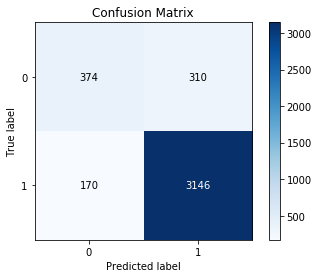

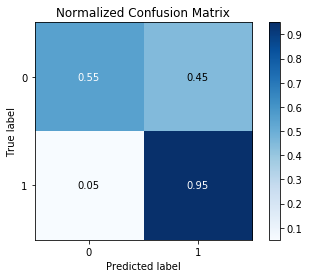

In [143]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(X_test_bow))
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(X_test_bow), normalize=True)

### [4.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [38]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)
tf_idf_tr = tf_idf_vect.fit_transform(X_tr['FinalReview'].values)
print("The shape of train TFIDF vectorizer ",tf_idf_tr.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_train = hstack((tf_idf_tr,np.array(X_tr['word_count'])[:,None]))
print("The shape of train text BOW after adding word_count ",final_train.get_shape())

# Data-preprocessing: Standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
x_scaled_tr = scaler.fit_transform(final_train)

# Converting sparse matrices to dense
standardized_data_train_dense =x_scaled_tr.toarray()

The shape of train TFIDF vectorizer  (12800, 500)
The shape of train text BOW after adding word_count  (12800, 501)


In [39]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_tfidf, y_train_tfidf = sm.fit_resample(standardized_data_train_dense, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_tfidf))

Resampled dataset shape Counter({0: 10979, 1: 10979})


In [40]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_tfidf).items()))

Train data before upsampling:  [(0, 1821), (1, 10979)]
Train data after upsampling :  [(0, 10979), (1, 10979)]


In [41]:
#BoW: 
tf_idf_cv = tf_idf_vect.transform(X_cv['FinalReview'].values)
print("The shape of cv text TFIDF vectorizer ",tf_idf_cv.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_cv = hstack((tf_idf_cv,np.array(X_cv['word_count'])[:,None]))
print("The shape of cv text BOW after adding word_count ",final_cv.get_shape())

# Data-preprocessing: Standardizing the data
standardized_data_cv = scaler.transform(final_cv)

# Converting sparse matrices to dense
X_cv_tfidf =standardized_data_cv.toarray()

The shape of cv text TFIDF vectorizer  (3200, 500)
The shape of cv text BOW after adding word_count  (3200, 501)


In [42]:
tf_idf_test = tf_idf_vect.transform(X_test['FinalReview'].values)
print("The shape of test TFIDF vectorizer ",tf_idf_test.get_shape())

# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix
from scipy.sparse import hstack
final_test = hstack((tf_idf_test,np.array(X_test['word_count'])[:,None]))
print("The shape of test text BOW after adding word_count ",final_test.get_shape())

# Data-preprocessing: Standardizing the data
standardized_data_test = scaler.transform(final_test)

# Converting sparse matrices to dense
X_test_tfidf =standardized_data_test.toarray()

The shape of test TFIDF vectorizer  (4000, 500)
The shape of test text BOW after adding word_count  (4000, 501)


For values of alpha =  0.0001 The auc score is: 0.5599915648897374
For values of alpha =  0.001 The auc score is: 0.5599915648897374
For values of alpha =  0.01 The auc score is: 0.6766827287329151
For values of alpha =  0.1 The auc score is: 0.8594783869240638
For values of alpha =  1 The auc score is: 0.8981226828701598
For values of alpha =  10 The auc score is: 0.8971112272832884
For values of alpha =  100 The auc score is: 0.8969167651604691
For values of alpha =  1000 The auc score is: 0.8746211776828197


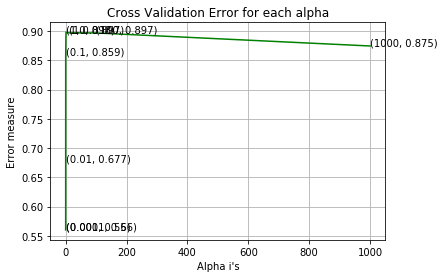

For values of best alpha =  1 The train auc score is: 0.9939107931551895
For values of best alpha =  1 The test auc score is: 0.8882958461318273


In [45]:
# code copied from Quora question Pair Similarity Problem case study

from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
alpha = [10 ** x for x in range(-4,4)] 

auc_score_array=[]

for i in alpha:
    clf = SVC(C=i, kernel='rbf', random_state=42, class_weight= 'balanced')
    clf.fit(X_train_tfidf, y_train_tfidf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_tfidf, y_train_tfidf)
    predict_y = sig_clf.predict_proba(X_cv_tfidf)[:,1]
    auc_score_array.append(roc_auc_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The auc score is:",roc_auc_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, auc_score_array,c='g')
for i, txt in enumerate(np.round(auc_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],auc_score_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(auc_score_array)
clf = SVC(C=alpha[best_alpha], kernel='rbf', random_state=42, class_weight= 'balanced')
clf.fit(X_train_tfidf, y_train_tfidf)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_tfidf, y_train_tfidf)

predict_y = sig_clf.predict_proba(X_train_tfidf)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The train auc score is:",roc_auc_score(y_train_tfidf, predict_y))
predict_y = sig_clf.predict_proba(X_test_tfidf)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The test auc score is:",roc_auc_score(y_test, predict_y))

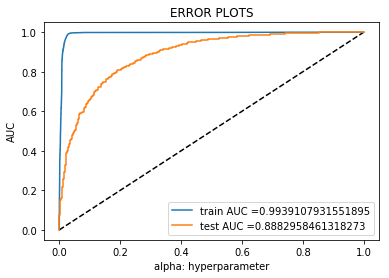

Train confusion matrix
[[10560   419]
 [   47 10932]]
Test confusion matrix
[[ 217  468]
 [  42 3273]]


In [46]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

predict_y = sig_clf.predict_proba(X_train_tfidf)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf, predict_y)
predict_y = sig_clf.predict_proba(X_test_tfidf)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_y)

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf, sig_clf.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, sig_clf.predict(X_test_tfidf)))

Confusion matrix for TRAIN data


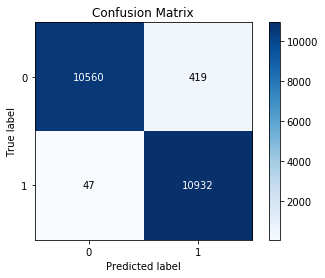

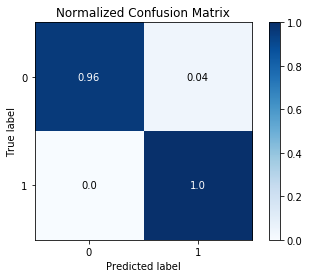

In [52]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_tfidf, sig_clf.predict(X_train_tfidf))
skplt.metrics.plot_confusion_matrix(y_train_tfidf, sig_clf.predict(X_train_tfidf), normalize=True)

Confusion matrix for TEST data


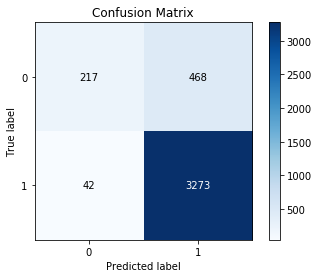

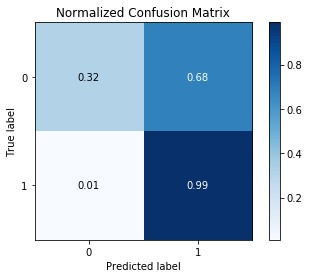

In [53]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(X_test_tfidf))
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(X_test_tfidf), normalize=True)

## Word2Vec

In [162]:
# Train the Word2Vec model using text corpus
i=0
list_of_sent_train=[]
list_of_sent_cv=[]
list_of_sent_test=[]
for sent in X_tr['FinalReview'].values:
    list_of_sent_train.append(sent.split())
    
for sent in X_cv['FinalReview'].values:
    list_of_sent_cv.append(sent.split())
    
for sent in X_test['FinalReview'].values:
    list_of_sent_test.append(sent.split())

In [163]:

# Train data
print(X_tr['FinalReview'].values[0])
print("*****************************************************************")
print(list_of_sent_train[0])
print("*****************************************************************")

# CV data
print(X_cv['FinalReview'].values[0])
print("*****************************************************************")
print(list_of_sent_cv[0])
print("*****************************************************************")

# Test data
print(X_test['FinalReview'].values[0])
print("*****************************************************************")
print(list_of_sent_test[0])

buy neighborhood supermarket really best soymilk best flavor best texture everything really best
*****************************************************************
['buy', 'neighborhood', 'supermarket', 'really', 'best', 'soymilk', 'best', 'flavor', 'best', 'texture', 'everything', 'really', 'best']
*****************************************************************
texas drought made local fresh fruit scarce season resorted canned fruits sale fifteen ish nice right neither mushy firm sweet bland know canned fruits not good fresh pretty good california fruit libby serving size also enough leave satisfied one serving easily portable go lunches snacks worth interesting experiences imported peaches grainy gritty like pears yuckiest peaches ever thought opened wrong fruit discernible peaches texture taste right though california yummies
*****************************************************************
['texas', 'drought', 'made', 'local', 'fresh', 'fruit', 'scarce', 'season', 'resorted', 'can

In [164]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)

In [165]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("Number of words that occured minimum 5 times in the train data: ",len(w2v_words_train))
print("Sample words in train data: ", w2v_words_train[0:50])

Number of words that occured minimum 5 times in the train data:  7282
Sample words in train data:  ['darker', 'distribution', 'conditioned', 'reads', 'set', 'rainbow', 'satisfactory', 'chocolaty', 'benecol', 'cinammon', 'enfamil', 'rosebuds', 'drowsy', 'palates', 'terrier', 'inulin', 'finest', 'movie', 'seattle', 'complaint', 'hungarian', 'exceptionally', 'intolerance', 'martinis', 'apricot', 'postum', 'trace', 'oyster', 'couscous', 'hexane', 'ladies', 'cutter', 'securely', 'prone', 'forth', 'increases', 'whether', 'older', 'bonkers', 'cakesters', 'figs', 'teething', 'gosh', 'schools', 'copper', 'ireland', 'alfredo', 'limiting', 'gumball', 'received']


In [166]:
w2v_model_train.wv.most_similar('taste')

[('tastes', 0.9247570037841797),
 ('aftertaste', 0.9102119207382202),
 ('flavor', 0.8801506161689758),
 ('smells', 0.8578864932060242),
 ('nothing', 0.8490460515022278),
 ('bland', 0.8328066468238831),
 ('overly', 0.826274573802948),
 ('soda', 0.8239180445671082),
 ('overpowering', 0.8190947771072388),
 ('overwhelming', 0.8171582221984863)]

### [4.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [168]:
# average Word2Vec for train data
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

12800
50


In [169]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_w2v, y_train_w2v = sm.fit_resample(sent_vectors_train, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_w2v))

Resampled dataset shape Counter({0: 10879, 1: 10879})


In [170]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_w2v).items()))

Train data before upsampling:  [(0, 1921), (1, 10879)]
Train data after upsampling :  [(0, 10879), (1, 10879)]


In [173]:
# average Word2Vec for test data
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

4000
50


In [176]:
# average Word2Vec for cv data
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

3200
50


In [177]:
# Data-preprocessing: Standardizing both train and test data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_data_train = scaler.fit_transform(X_train_w2v)
standardized_data_cv = scaler.transform(sent_vectors_cv)
standardized_data_test = scaler.transform(sent_vectors_test)

For values of alpha =  0.0001 The auc score is: 0.7889491596683378
For values of alpha =  0.001 The auc score is: 0.7889491596683378
For values of alpha =  0.01 The auc score is: 0.855516439420549
For values of alpha =  0.1 The auc score is: 0.8912351917488903
For values of alpha =  1 The auc score is: 0.9006084288618534
For values of alpha =  10 The auc score is: 0.8947250428414812
For values of alpha =  100 The auc score is: 0.876038440250769
For values of alpha =  1000 The auc score is: 0.864285638258241


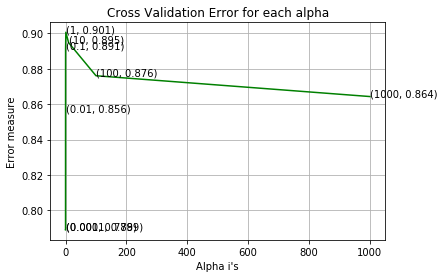

For values of best alpha =  1 The train auc score is: 0.9561639186403961
For values of best alpha =  1 The test auc score is: 0.8880772120288659


In [178]:
# code copied from Quora question Pair Similarity Problem case study

from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
alpha = [10 ** x for x in range(-4,4)] 

auc_score_array=[]

for i in alpha:
    clf = SVC(C=i, kernel='rbf', random_state=42, class_weight= 'balanced')
    clf.fit(standardized_data_train, y_train_w2v)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(standardized_data_train, y_train_w2v)
    predict_y = sig_clf.predict_proba(standardized_data_cv)[:,1]
    auc_score_array.append(roc_auc_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The auc score is:",roc_auc_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, auc_score_array,c='g')
for i, txt in enumerate(np.round(auc_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],auc_score_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(auc_score_array)
clf = SVC(C=alpha[best_alpha], kernel='rbf', random_state=42, class_weight= 'balanced')
clf.fit(standardized_data_train, y_train_w2v)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(standardized_data_train, y_train_w2v)

predict_y = sig_clf.predict_proba(standardized_data_train)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The train auc score is:",roc_auc_score(y_train_w2v, predict_y))
predict_y = sig_clf.predict_proba(standardized_data_test)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The test auc score is:",roc_auc_score(y_test, predict_y))

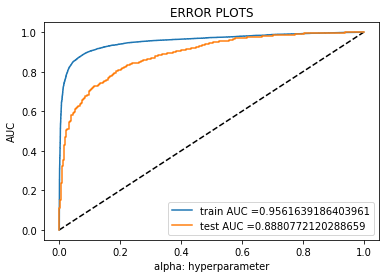

Train confusion matrix
[[10153   726]
 [ 1353  9526]]
Test confusion matrix
[[ 501  183]
 [ 488 2828]]


In [179]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

predict_y = sig_clf.predict_proba(standardized_data_train)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_w2v, predict_y)
predict_y = sig_clf.predict_proba(standardized_data_test)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_y)

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_w2v, sig_clf.predict(standardized_data_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, sig_clf.predict(standardized_data_test)))

Confusion matrix for TRAIN data


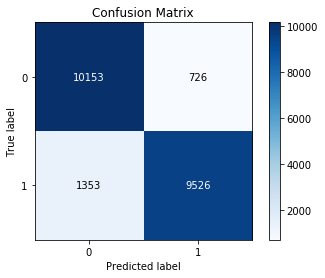

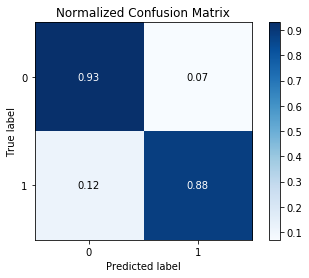

In [180]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_w2v, sig_clf.predict(standardized_data_train))
skplt.metrics.plot_confusion_matrix(y_train_w2v, sig_clf.predict(standardized_data_train), normalize=True)

Confusion matrix for TEST data


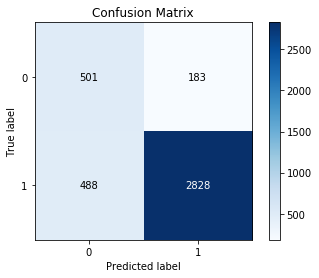

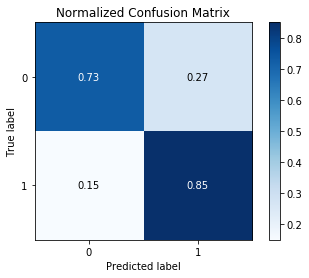

In [181]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(standardized_data_test))
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(standardized_data_test), normalize=True)

### [4.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [182]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_tr['FinalReview'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model.get_feature_names(), list(model.idf_)))

In [183]:
tf_idf_matrix_cv = model.transform(X_cv['FinalReview'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary_cv = dict(zip(model.get_feature_names(), list(model.idf_)))

In [184]:
tf_idf_matrix_test = model.transform(X_test['FinalReview'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary_test = dict(zip(model.get_feature_names(), list(model.idf_)))

In [186]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_train = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf_train)
            weight_sum += tf_idf_train
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [187]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_tfidf_w2v, y_train_tfidf_w2v = sm.fit_resample(tfidf_sent_vectors_train, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_tfidf_w2v))

Resampled dataset shape Counter({0: 10879, 1: 10879})


In [188]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_tfidf_w2v).items()))

Train data before upsampling:  [(0, 1921), (1, 10879)]
Train data after upsampling :  [(0, 10879), (1, 10879)]


In [189]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_cv = dictionary_cv[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf_cv)
            weight_sum += tf_idf_cv
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

In [190]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_test = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf_test)
            weight_sum += tf_idf_test
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [191]:
# Data-preprocessing: Standardizing both train and test data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_data_train = scaler.fit_transform(X_train_tfidf_w2v)
standardized_data_cv = scaler.transform(tfidf_sent_vectors_cv)
standardized_data_test = scaler.transform(tfidf_sent_vectors_test)

For values of alpha =  0.0001 The auc score is: 0.7485876946493384
For values of alpha =  0.001 The auc score is: 0.7485876946493384
For values of alpha =  0.01 The auc score is: 0.8161701312386244
For values of alpha =  0.1 The auc score is: 0.8602243456695512
For values of alpha =  1 The auc score is: 0.8707757235154496
For values of alpha =  10 The auc score is: 0.8670490468435674
For values of alpha =  100 The auc score is: 0.8521882417430363
For values of alpha =  1000 The auc score is: 0.8368158667816202


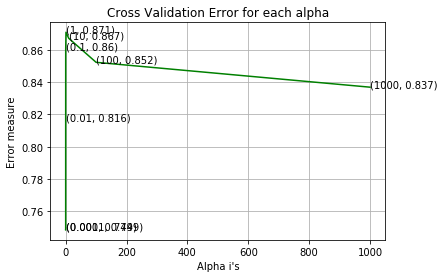

For values of best alpha =  1 The train auc score is: 0.9448570902612979
For values of best alpha =  1 The test auc score is: 0.8697371066387319


In [192]:
# code copied from Quora question Pair Similarity Problem case study

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
alpha = [10 ** x for x in range(-4,4)] 

auc_score_array=[]

for i in alpha:
    clf = SVC(C=i, kernel='rbf', random_state=42, class_weight= 'balanced')
    clf.fit(standardized_data_train, y_train_tfidf_w2v)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(standardized_data_train, y_train_tfidf_w2v)
    predict_y = sig_clf.predict_proba(standardized_data_cv)[:,1]
    auc_score_array.append(roc_auc_score(y_cv, predict_y))
    print('For values of alpha = ', i, "The auc score is:",roc_auc_score(y_cv, predict_y))

fig, ax = plt.subplots()
ax.plot(alpha, auc_score_array,c='g')
for i, txt in enumerate(np.round(auc_score_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],auc_score_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(auc_score_array)
clf = SVC(C=alpha[best_alpha], kernel='rbf', random_state=42, class_weight= 'balanced')
clf.fit(standardized_data_train, y_train_tfidf_w2v)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(standardized_data_train, y_train_tfidf_w2v)

predict_y = sig_clf.predict_proba(standardized_data_train)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The train auc score is:",roc_auc_score(y_train_tfidf_w2v, predict_y))
predict_y = sig_clf.predict_proba(standardized_data_test)[:,1]
print('For values of best alpha = ', alpha[best_alpha], "The test auc score is:",roc_auc_score(y_test, predict_y))

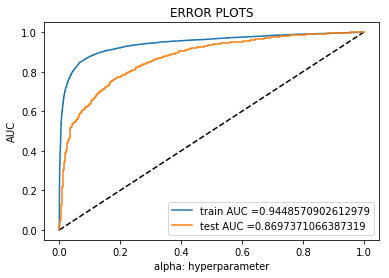

Train confusion matrix
[[10006   873]
 [ 1528  9351]]
Test confusion matrix
[[ 495  189]
 [ 539 2777]]


In [193]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

predict_y = sig_clf.predict_proba(standardized_data_train)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf_w2v, predict_y)
predict_y = sig_clf.predict_proba(standardized_data_test)[:,1]
test_fpr, test_tpr, thresholds = roc_curve(y_test, predict_y)

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf_w2v, sig_clf.predict(standardized_data_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, sig_clf.predict(standardized_data_test)))

Confusion matrix for TRAIN data


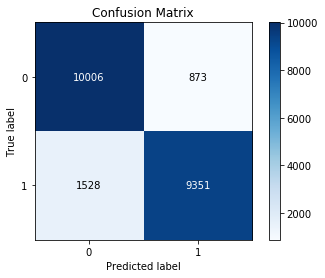

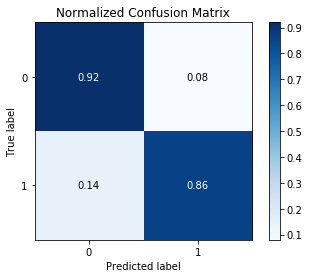

In [194]:
import scikitplot as skplt

print("Confusion matrix for TRAIN data")
skplt.metrics.plot_confusion_matrix(y_train_tfidf_w2v, sig_clf.predict(standardized_data_train))
skplt.metrics.plot_confusion_matrix(y_train_tfidf_w2v, sig_clf.predict(standardized_data_train), normalize=True)

Confusion matrix for TEST data


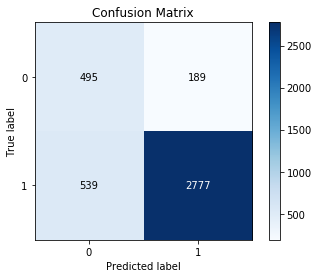

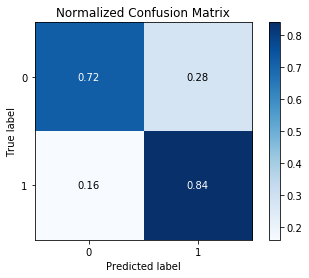

In [195]:
print("Confusion matrix for TEST data")
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(standardized_data_test))
skplt.metrics.plot_confusion_matrix(y_test, sig_clf.predict(standardized_data_test), normalize=True)

# [5] Conclusions

In [54]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["SVM", "Vectorizer", "Regularization", "Hyper parameter", "Train AUC", "Test AUC"]

x.add_row(["Linear Kernal", "BOW", "L1",  0.01, 0.852, 0.739])
x.add_row(["Linear Kernal", "BOW", "L2", 10000, 0.999, 0.909])
x.add_row(["Linear Kernal", "TFIDF", "L1", 0.001, 0.997, 0.875])
x.add_row(["Linear Kernal", "TFIDF", "L2", 10, 0.999, 0.909])
x.add_row(["Linear Kernal", "AVG W2V", "L1", 0.01, 0.938, 0.908])
x.add_row(["Linear Kernal", "AVG W2V", "L2", 1, 0.929, 0.911])
x.add_row(["Linear Kernal", "TFTDF W2V", "L1", 0.001, 0.919, 0.909])
x.add_row(["Linear Kernal", "TFTDF W2V", "L2", 0.001, 0.919, 0.910])
x.add_row(["RBF Kernal", "BOW", "-", 1, 0.992, 0.883])
x.add_row(["RBF Kernal", "TFIDF", "-", 1, 0.993, 0.888])
x.add_row(["RBF Kernal", "AVG W2V", "-", 1, 0.956, 0.888])
x.add_row(["RBF Kernal", "TFIDF W2V", "-", 1, 0.945, 0.869])


print(x)

+---------------+------------+----------------+-----------------+-----------+----------+
|      SVM      | Vectorizer | Regularization | Hyper parameter | Train AUC | Test AUC |
+---------------+------------+----------------+-----------------+-----------+----------+
| Linear Kernal |    BOW     |       L1       |       0.01      |   0.852   |  0.739   |
| Linear Kernal |    BOW     |       L2       |      10000      |   0.999   |  0.909   |
| Linear Kernal |   TFIDF    |       L1       |      0.001      |   0.997   |  0.875   |
| Linear Kernal |   TFIDF    |       L2       |        10       |   0.999   |  0.909   |
| Linear Kernal |  AVG W2V   |       L1       |       0.01      |   0.938   |  0.908   |
| Linear Kernal |  AVG W2V   |       L2       |        1        |   0.929   |  0.911   |
| Linear Kernal | TFTDF W2V  |       L1       |      0.001      |   0.919   |  0.909   |
| Linear Kernal | TFTDF W2V  |       L2       |      0.001      |   0.919   |   0.91   |
|   RBF Kernal  |    